# Trustworthy Artificial Intelligence - 20.12.2022 Exam

This exam is composed of 3 different exercises, for a total score of **18 points**.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/fabiogueunige/Trustworthy/blob/HEAD/Old_Tony_last_year.ipynb)

In [ ]:
try:
 import secml
except ImportError:
 %pip install git+https://github.com/pralab/secml
 %pip install foolbox

In [ ]:
from secml.data.splitter import CTrainTestSplit
from secml.data.loader import CDLRandomBlobs

random_state = 444

n_features = 2 # number of features
centers = [[2, -2], [2, 2], [-2,0]] # centers of the clusters
cluster_std = 0.6 # standard deviation of the clusters
n_classes = len(centers) # number of classes

n_tr = 1000 # Number of training set samples
n_ts = 100 # Number of test set samples

n_samples = n_ts + n_tr # number of samples

dataset = CDLRandomBlobs(n_features=n_features,
 centers=centers,
 cluster_std=cluster_std,
 n_samples=n_samples,
 random_state=random_state).load()

splitter = CTrainTestSplit(
 train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit(dataset.X).transform(tr.X)
ts.X = nmz.transform(ts.X)

In [ ]:
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.show()

# Exercise 1 (6 Points)

Complete the following tasks using SecML:
* Fit a SVM using the ad-hoc SecML class on the provided training set, with default hyper- parameters
* Compute the accuracy on the test set using the CMetricAccuracy object
* Plot the learned decision function using the ad-hoc method of the CFigure class

In [ ]:
from sklearn.svm import SVC
from secml.ml.classifiers import CClassifierSkLearn
from secml.ml import CClassifierSVM

secml_model = CClassifierSVM()
secml_model.fit(tr.X, tr.Y)

from secml.ml.peval.metrics import CMetricAccuracy

y_pred = secml_model.predict(ts.X)
accuracy = CMetricAccuracy().performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on the test set", accuracy)

Accuracy on the test set 1.0


In [ ]:
fig = CFigure(width=5, height=5)
fig.sp.plot_decision_regions(secml_model, n_grid_points=200)
fig.sp.plot_ds(ts)
fig.sp.grid(grid_on=False)

fig.show()

# Exercise 2 (10 Points)

Compute a security evaluation curve of the trained model using SecML, with the following setup:
* use the CFoolboxPGDLInf attack from the SecML library, with 20 iterations and 0.05 as absolute step size, no random start, lower bound 0 and upper bound 1
* use at least 8 values for the perturbation budget $\epsilon$. Which maximum value should you pick, starting from zero?
* plot the security evaluation curve using the ad-hoc method of the CFigure class

In [ ]:
from secml.adv.attacks import CFoolboxPGDLinf
from secml.array import CArray
from secml.ml.peval.metrics import CMetricAccuracy
from secml.ml.classifiers import CClassifierPyTorch

eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
robust_accuracies = []
metric = CMetricAccuracy()
pgd_attack = CFoolboxPGDLinf(
 secml_model,
 steps=20,
 epsilons=eps,
 abs_stepsize=0.05,
 random_start=False,
 lb=0,
 ub=1)
sec_eval = CSecEval(pgd_attack, param_name='epsilon', param_values=eps)
sec_eval.run_sec_eval(ts)

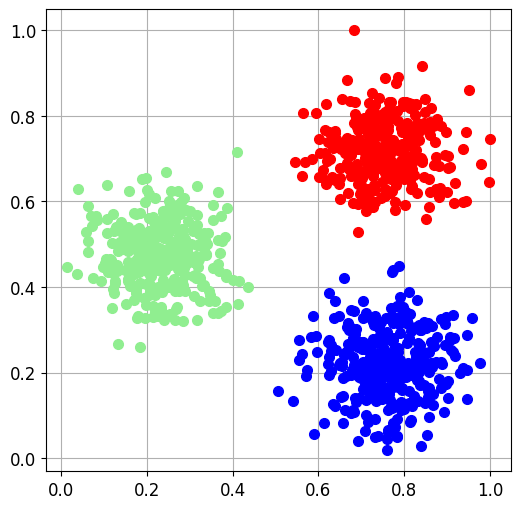

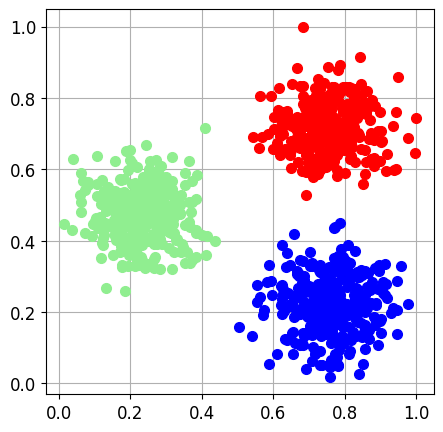

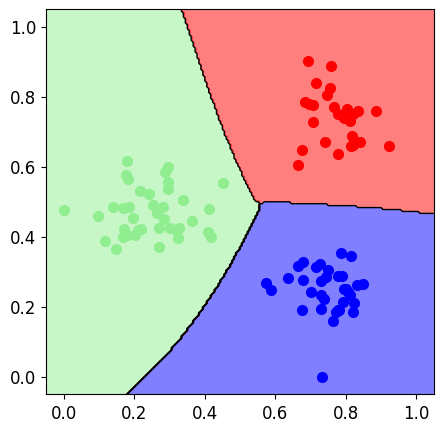

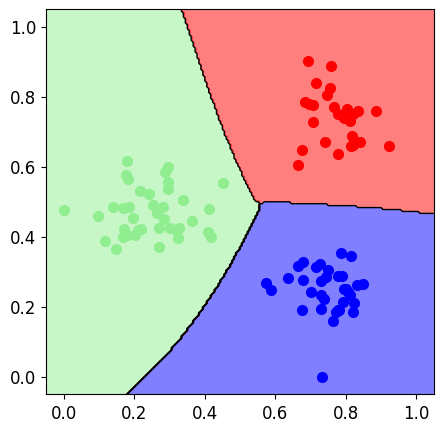

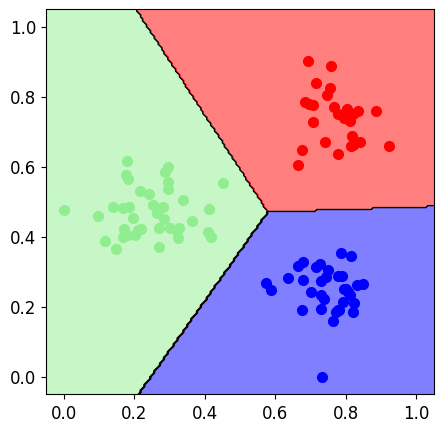

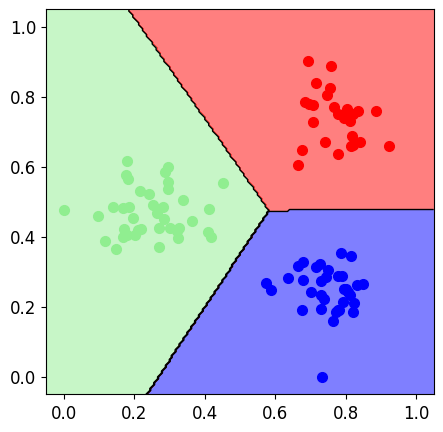

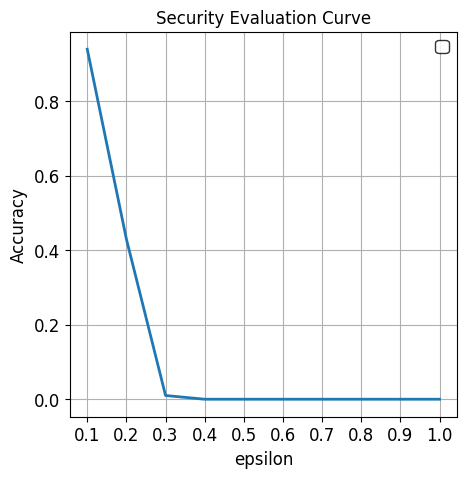

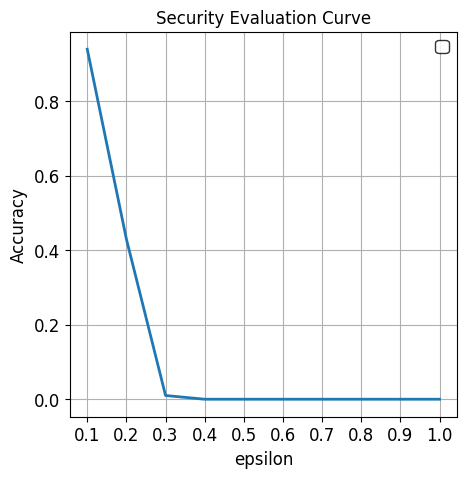

In [ ]:
%matplotlib inline
fig = CFigure(width=5, height=5)
fig.sp.plot_sec_eval(sec_eval.sec_eval_data)
fig.show()

# Exercise 3 (2 Points)

Find and fix the bug of the proposed implementation of PGD L2, and execute it against the trained classifer.

In [ ]:
from secml.array import CArray
from secml.ml import CClassifier
from secml.ml.classifiers.loss import CLossCrossEntropy


def pgd_l2_targeted(clf : CClassifier, x : CArray, y_original : CArray, y_target : int, steps : int=20, eps : float=0.5, step_size : float=0.05, lb : int = 0, ub : int = 1):
    loss_func = CLossCrossEntropy()
    x_adv = x.deepcopy()
    path = CArray.zeros((steps, 2))
    for i in range(steps):
        scores = clf.decision_function(x_adv)
        loss_gradient = loss_func.dloss(y_true=y_original, score=scores, pos_label=y_target)
        clf_gradient = clf.grad_f_x(x_adv, y_target)
        gradient = clf_gradient * loss_gradient

        if gradient.norm() != 0:
            gradient /= gradient.norm()

        x_adv = x_adv + step_size * gradient
        delta = x_adv - x
        if delta.norm() > eps:
            delta = delta / delta.norm()
            x_adv = x + delta * eps

        x_adv = x_adv.clip(lb, ub)
        path[i, :] = x_adv

    scores = clf.decision_function(x_adv)
    print(f'Adv label: {scores.argmax()}')
    return x_adv, path

sample, label = tr.X[0,:], tr.Y[0]

# TODO call the function using the trained classifier at exercise 1

Original label 0
Adv label: 2


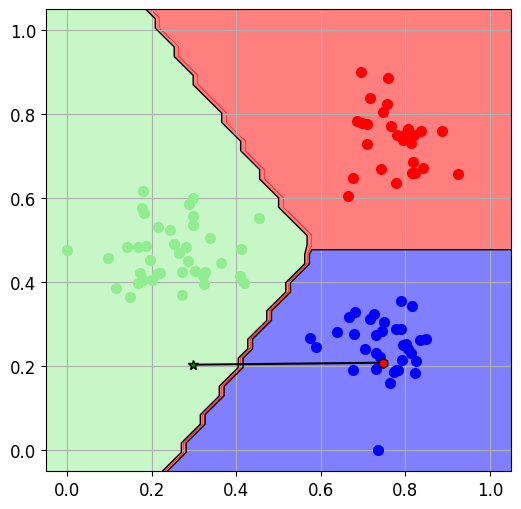

In [ ]:
print("Original label", label.item())
x_adv, path = pgd_l2_targeted(secml_model, sample, label, 2)

fig = CFigure()
fig.sp.plot_decision_regions(secml_model, n_grid_points=50)
fig.sp.plot_ds(ts)
fig.sp.plot_path(path)